In [14]:
import os, json, io, nltk, re
from collections import Counter 
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

In [15]:
path_to_folder = "C:/Users/monte/_Olesya/Диплом/Основная папка/задание/Distances_between_articles_cat_NLP"
categ = json.load(open("C:/Users/monte/_Olesya/Диплом/Основная папка/задание/NatLangProc_Categ.json", "r", encoding="utf-8"))

In [16]:
@dataclass
class dist_to_root_art:
    idx: int
    art_name: str    
    distance: float
        
def my_comp_distance(x):
    return x.distance

In [17]:
def matrix_creator (name):
    art_dict = json.load(open(path_to_folder + "/" + name + ".json", "r", encoding="utf-8"))
    matrix = np.ones((203, 203))
    for i in art_dict:
        for j in art_dict[i]["distances"]:
            matrix[int(i)][int(j)] = 1 - art_dict[i]["distances"][j]["distance"]
    return matrix

In [18]:
matrix = matrix_creator("NLP_distances_result")

In [19]:
def kmedoids_manual_with_central_first(distance_matrix, k, max_iter=100, random_state=42):
    np.random.seed(random_state)
    n = distance_matrix.shape[0]
    
    # 1. Случайный выбор начальных медоидов
    medoids = np.random.choice(n, k, replace=False)
    labels = np.zeros(n, dtype=int)
    
    for iteration in range(max_iter):
        # 2. Назначение к ближайшему медоиду
        for i in range(n):
            distances_to_medoids = [distance_matrix[i][m] for m in medoids]
            labels[i] = np.argmin(distances_to_medoids)

        # 3. Пересчёт медоидов
        new_medoids = []
        for cluster_id in range(k):
            cluster_points = np.where(labels == cluster_id)[0]
            if len(cluster_points) == 0:
                new_medoids.append(np.random.choice(n))
                continue
            min_total_dist = float('inf')
            best_medoid = cluster_points[0]
            for candidate in cluster_points:
                total_dist = np.sum(distance_matrix[candidate][cluster_points])
                if total_dist < min_total_dist:
                    min_total_dist = total_dist
                    best_medoid = candidate
            new_medoids.append(best_medoid)

        if np.array_equal(medoids, new_medoids):
            break
        medoids = new_medoids

    labels = np.array(labels)

    # === Дополнительный шаг: переименование кластеров, чтобы центральный был 0 ===
    external_avg_distances = []
    for cluster_id in range(k):
        in_cluster = np.where(labels == cluster_id)[0]
        out_cluster = np.where(labels != cluster_id)[0]
        if len(in_cluster) == 0 or len(out_cluster) == 0:
            external_avg_distances.append(np.inf)
            continue
        total_dist = np.sum(distance_matrix[np.ix_(in_cluster, out_cluster)])
        avg_dist = total_dist / (len(in_cluster) * len(out_cluster))
        external_avg_distances.append(avg_dist)

    most_central_cluster = np.argmin(external_avg_distances)

    # Переименование меток
    new_labels = np.zeros_like(labels)
    label_mapping = {most_central_cluster: 0}
    next_label = 1
    for old_label in range(k):
        if old_label == most_central_cluster:
            continue
        label_mapping[old_label] = next_label
        next_label += 1

    for i in range(len(labels)):
        new_labels[i] = label_mapping[labels[i]]

    # Обновим порядок медоидов в соответствии с новыми номерами
    reordered_medoids = [None] * k
    for old_label, new_label in label_mapping.items():
        reordered_medoids[new_label] = medoids[old_label]

    return new_labels.tolist()

In [20]:
def visualize_clustering(distance_matrix, clusters, title="KMedoids Clustering Visualization"):
    # Преобразуем матрицу расстояний в 2D-координаты с помощью MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)

    clusters = np.array(clusters)
    unique_clusters = np.unique(clusters)

    # Палитра цветов
    colors = plt.cm.get_cmap('tab10', len(unique_clusters))

    # Визуализация
    plt.figure(figsize=(8, 6))
    for idx, cluster_id in enumerate(unique_clusters):
        cluster_points = coords[clusters == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    label=f"Cluster {cluster_id}", s=100, alpha=0.7, c=[colors(idx)])

    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(i), fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
n_clusters = 10
labels = kmedoids_manual_with_central_first(matrix, n_clusters)
print("Метки кластеров:", labels)

Метки кластеров: [0, 9, 8, 1, 6, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 1, 9, 8, 8, 0, 8, 8, 8, 2, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 1, 8, 5, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 1, 8, 1, 8, 8, 8, 6, 1, 9, 8, 6, 1, 8, 9, 8, 8, 8, 8, 2, 3, 8, 8, 8, 8, 8, 1, 9, 8, 8, 8, 9, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 1, 8, 9, 8, 8, 8, 8, 9, 8, 8, 9, 8, 8, 8, 8, 0, 8, 2, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 9, 9, 2, 1, 1, 8, 1, 8, 6, 8, 8, 5, 1, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 9, 4, 8, 5, 8, 8, 1, 8, 9, 8, 1, 5, 8, 2, 8, 1, 9, 1, 9, 7, 8, 8, 9, 8, 7, 8, 8, 9, 8, 1, 6, 8, 8, 8, 2, 2, 8, 7, 8, 8, 9, 8, 8, 8, 8]


C:\Users\monte\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
C:\Users\monte\AppData\Local\Temp\ipykernel_17896\3432143368.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))


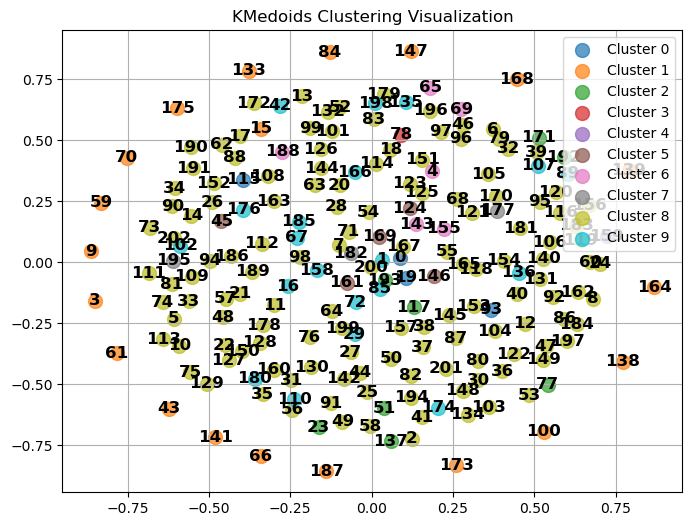

In [22]:
visualize_clustering(matrix, labels)

In [23]:
def leaders(name, labels):
    art_dict = json.load(open(path_to_folder + "/" + name + ".json", "r", encoding="utf-8"))
    for i in art_dict:
        if (labels[int(i)] == 0):
            print (art_dict[i]["art_name"])

In [24]:
leaders("NLP_distances_result", labels)

Natural language processing
Automatic summarization
Lexical Markup Framework
Multilingual notation


In [25]:
#Сравним с суммами

In [26]:
def art_sum_dist (name):
    art_dict = json.load(open(path_to_folder + "/" + name + ".json", "r", encoding="utf-8"))
    sum_list = []
    for i in art_dict:
        sum_el = 0
        for j in art_dict[i]["distances"]:
            sum_el += art_dict[i]["distances"][j]["distance"]
        c = []
        c = [i, art_dict[i]["art_name"], sum_el]
        sum_list.append(c)
    return sum_list

In [31]:
def print_sorted(name, name_json):
    # Создаем DataFrame и сортируем его по 'Sum_of_coef'
    df = pd.DataFrame(art_sum_dist(name_json), columns=['Index_in_cat', 'Name_of_art', 'Sum_of_coef'])
    df = df.sort_values('Sum_of_coef', ascending=False)
    
    
    # Переназначаем индексы
    df.index = range(len(df))
    df.index.name = 'New indexes'

    # Преобразуем индекс в столбец для построения графиков
    df = df.reset_index()

    # Выводим первые 36 строк
    print(df)
    
    

In [32]:
print_sorted("Natural language processing", "NLP_distances_result")

     New indexes Index_in_cat                             Name_of_art  \
0              0            1  Outline of natural language processing   
1              1          200               Word-sense disambiguation   
2              2            0             Natural language processing   
3              3           19                 Automatic summarization   
4              4           85                Latent semantic analysis   
..           ...          ...                                     ...   
179          179           65                               Grammatik   
180          180          137           Production (computer science)   
181          181          190                     TipTop Technologies   
182          182           77                             Kleene star   
183          183          172  Studies in Natural Language Processing   

     Sum_of_coef  
0      75.439898  
1      61.080597  
2      59.095153  
3      57.877228  
4      57.529597  
..       